# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных.

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


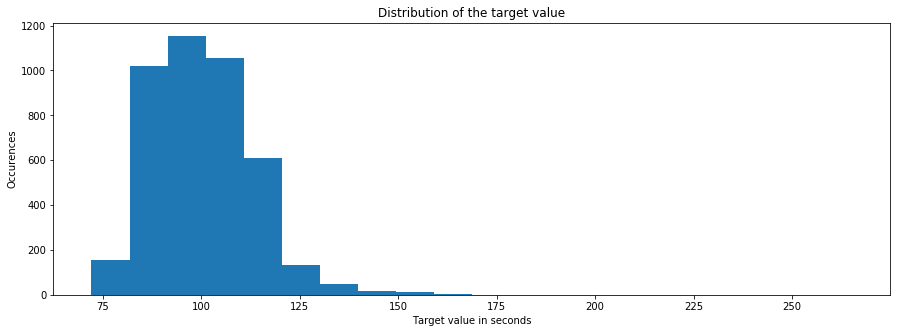

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [4]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [5]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1, inplace = True) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,X252,X87,X304,X229,X255,X346,X308,X96,X209,X94,...,X368,X249,X345,X60,X318,X228,X164,X281,X66,X29
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [6]:
x_train.shape, y_train.shape

((4209, 364), (4209,))

In [7]:
from sklearn.utils import shuffle

In [8]:
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [9]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 364), (2000,))

In [10]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 364), (1000,))

In [11]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 364), (1209,))

## Настройка моделей

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

### Random Forest - подбор гиперпараметров

In [13]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [14]:
gs.fit(x1, y1)

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-0.415, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-1.374, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-0.043, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ..................... n_estimators=2, score=-0.010, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ..................... n_estimators=2, score=-0.270, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.158, total=   0.1s
[CV] n_estimators=4 ..................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': array([  1,   

Text(0, 0.5, 'R2')

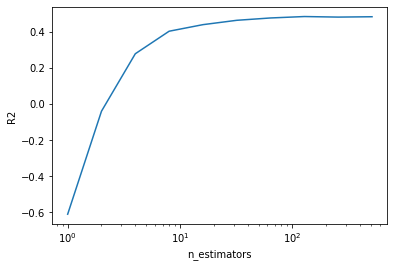

In [15]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [16]:
#Для случайного леса самый важный гиперпараметр - max_features, потому что он влияет на то, насколько различными будут деревья. 
# После настройки max_features подбираются остальные гиперпараметры.

# базовая логарифмическая шкала для max_features
param_grid2 = {"max_features":2**np.arange(1, 9)}

In [17]:
gs2 = GridSearchCV(RandomForestRegressor(random_state=1,warm_start=True), param_grid2, make_scorer(r2_score), verbose=3)

In [18]:
gs2.fit(x1,y1)

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.403, total=   0.1s
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.487, total=   0.0s
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.267, total=   0.0s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.422, total=   0.0s
[CV] max_features=4 ..................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

[CV] ...................... max_features=4, score=0.492, total=   0.1s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.288, total=   0.1s
[CV] max_features=8 ..................................................
[CV] ...................... max_features=8, score=0.469, total=   0.0s
[CV] max_features=8 ..................................................
[CV] ...................... max_features=8, score=0.521, total=   0.0s
[CV] max_features=8 ..................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

[CV] ...................... max_features=8, score=0.295, total=   0.1s
[CV] max_features=16 .................................................
[CV] ..................... max_features=16, score=0.466, total=   0.1s
[CV] max_features=16 .................................................
[CV] ..................... max_features=16, score=0.508, total=   0.1s
[CV] max_features=16 .................................................
[CV] ..................... max_features=16, score=0.342, total=   0.1s
[CV] max_features=32 .................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

[CV] ..................... max_features=32, score=0.462, total=   0.1s
[CV] max_features=32 .................................................
[CV] ..................... max_features=32, score=0.573, total=   0.1s
[CV] max_features=32 .................................................
[CV] ..................... max_features=32, score=0.350, total=   0.1s
[CV] max_features=64 .................................................
[CV] ..................... max_features=64, score=0.511, total=   0.1s
[CV] max_features=64 .................................................
[CV] ..................... max_features=64, score=0.544, total=   0.1s
[CV] max_features=64 .................................................
[CV] ..................... max_features=64, score=0.332, total=   0.1s
[CV] max_features=128 ................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................... max_features=128, score=0.466, total=   0.1s
[CV] max_features=128 ................................................
[CV] .................... max_features=128, score=0.517, total=   0.1s
[CV] max_features=128 ................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................... max_features=128, score=0.346, total=   0.1s
[CV] max_features=256 ................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................... max_features=256, score=0.500, total=   0.2s
[CV] max_features=256 ................................................
[CV] .................... max_features=256, score=0.529, total=   0.4s
[CV] max_features=256 ................................................


/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................... max_features=256, score=0.348, total=   0.3s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.4s finished
/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'max_features': array([  2,   

Text(0, 0.5, 'R2')

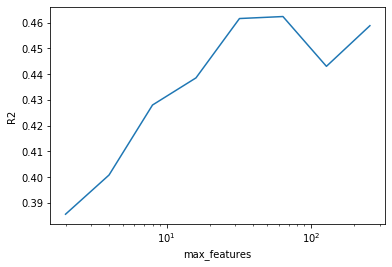

In [19]:
plt.plot((param_grid2["max_features"]), gs2.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_features")
plt.ylabel("R2")

In [20]:
gs2.best_params_

{'max_features': 64}

КОММЕНТАРИЙ: Такая взаимосвязь между количеством переменных и качеством модели была ожидаема. 
Повышение количества max_features может приводить к снижению качества модели на кросс-валидации в связи с переобучением. Неожиданным на графике можно считать появление "локотка". Так, сначала с повышением количества признаков в модели качество улучшается, затем снижается и вновь поднимается.
Наилучшее значение качества принимается при значении max_features, равном 64

In [21]:
# базовая шкала для остальных гиперпараметров
param_grid3 = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}

In [24]:
gs3 = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True, n_estimators = 100, max_features = 64), param_grid3, make_scorer(r2_score), verbose=3)

In [25]:
gs3.fit(x1,y1)

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.303, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.405, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.245, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.303, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.405, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.245, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.303, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.405, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.245, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_sample

[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=27, score=0.649, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=27, score=0.385, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=81, score=0.515, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=81, score=0.653, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=81, score=0.384, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=3, score=0.517, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samp

[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=81, score=0.407, total=   0.2s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, score=0.549, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, score=0.675, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=3, score=0.409, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=9, score=0.547, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=5, min_samples_leaf=3, min_samples_split=9, score=0.675, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=5, min_samples_leaf=3, min_samples_

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.549, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.671, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.405, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=27, score=0.550, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=27, score=0.673, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=27, score=0.408, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=81 ...........
[CV]  max_depth=7, min_samples_leaf=3, min_sample

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   43.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None, max_features=64,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([1, 3, 5, 7]),
                         'min_samples_leaf': [1,

In [26]:
gs3.best_params_

{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 81}

In [27]:
#обучение леса
RFR = RandomForestRegressor(random_state=1, warm_start=True, n_estimators = 500, max_features = 64, 
                            max_depth=7, min_samples_leaf = 3, min_samples_split = 81)
RFR.fit(x1, y1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features=64, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=81,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=True)

### Градиентный бустинг - подбор гиперпараметров

Для градиентного бустинга самые важные гиперпараметры - число деревьев и глубина дерева. Глубина дерева задает, насколько слабыми или сильными будут отдельные деревья, а значит и то, насколько мы будем двигаться в сторону градиента. После этих гиперпараметров подбираем другие гиперпараметры. 

In [28]:
# базовая шкала для числа деревьев и длины шага
param_grid4 = {"n_estimators":2**np.log2(np.arange(10)), "learning_rate":0.1**np.arange(5)}

In [29]:
gs4 = GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start = True), 
                   param_grid4, make_scorer(r2_score), verbose=3)

In [1]:
gs4.fit(x1,y1)

In [31]:
gs4.best_params_

{'learning_rate': 0.010000000000000002, 'n_estimators': 512}

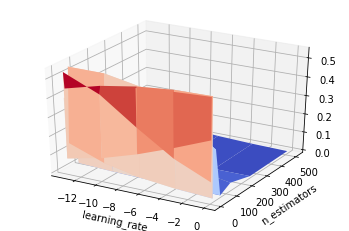

In [32]:
#график
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.log2(param_grid4["learning_rate"])
Y = param_grid4["n_estimators"]
X, Y = np.meshgrid(X, Y)
Z = gs4.cv_results_['mean_test_score'].reshape(10,5)
plt.xlabel("learning_rate")
plt.ylabel("n_estimators")

graph = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0)

plt.show()

КОММЕНТАРИЙ:
Оптимальное значение гиперпараметров: learning_rate': 0.010000000000000002, n_estimators: 512

In [34]:
# базовая шкала для max_depth
param_grid5 = {"max_depth":np.arange(1, 9)}

In [35]:
gs5 = GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start = True, 
                                             learning_rate = 0.010000000000000002,
                                            n_estimators = 512), 
                   param_grid5, make_scorer(r2_score), verbose=3)

In [36]:
gs5.fit(x1,y1)

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.501, total=   1.0s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.638, total=   1.1s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.379, total=   1.2s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.549, total=   2.4s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.680, total=   3.1s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.418, total=   2.4s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.546, total=   5.2s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.671, total=   4.9s
[CV] max_depth=3 .....................................................
[CV] ......................... max_depth=3, score=0.413, total=   6.1s
[CV] max_depth=4 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None,
                                                 learning_rate=0.010000000000000002,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=512,
                 

In [37]:
gs5.best_params_

{'max_depth': 2}

Text(0, 0.5, 'R2')

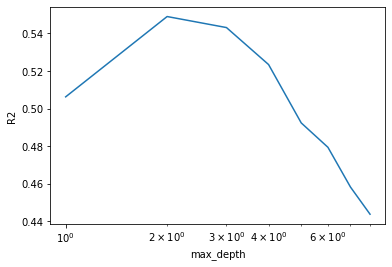

In [38]:
plt.plot((param_grid5["max_depth"]), gs5.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("R2")

КОММЕНТАРИЙ: График, с одной стороны, выглядит ожидаемо, поскольку маленькая глубина деревьев позволяет избежать переобучения. С другой стороны, увеличение глубины дерева по идее позволило бы ухватить более явно связи между признаками, повышая качество. В данном случае, оптимальное значение гиперпараметра max_depth составило 2.  

In [39]:
# базовая шкала для остальных гиперпараметров
param_grid6 = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}

In [40]:
gs6 = GridSearchCV(GradientBoostingRegressor(random_state=1, 
                                             warm_start = True, 
                                             learning_rate = 0.010000000000000002, 
                                             n_estimators = 512, 
                                             max_depth = 2), 
                   param_grid6, make_scorer(r2_score), verbose=3)

In [41]:
gs6.fit(x1,y1)
gs6.best_params_

/Users/vasilisavashenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.314, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.415, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.229, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.314, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.416, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.229, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.313, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.415, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_sample

[CV]  max_features=8, min_samples_leaf=1, min_samples_split=27, score=0.454, total=   0.2s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=27, score=0.585, total=   0.2s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=27, score=0.334, total=   0.2s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=81 ........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=81, score=0.455, total=   0.2s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=81 ........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=81, score=0.581, total=   0.2s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=81 ........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=81, score=0.334, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=3 .........
[CV]  max_features=8, min_sa

[CV]  max_features=32, min_samples_leaf=1, min_samples_split=81, score=0.538, total=   0.4s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=81 .......
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=81, score=0.667, total=   0.4s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=81 .......
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=81, score=0.398, total=   0.4s
[CV] max_features=32, min_samples_leaf=3, min_samples_split=3 ........
[CV]  max_features=32, min_samples_leaf=3, min_samples_split=3, score=0.540, total=   0.4s
[CV] max_features=32, min_samples_leaf=3, min_samples_split=3 ........
[CV]  max_features=32, min_samples_leaf=3, min_samples_split=3, score=0.667, total=   0.4s
[CV] max_features=32, min_samples_leaf=3, min_samples_split=3 ........
[CV]  max_features=32, min_samples_leaf=3, min_samples_split=3, score=0.399, total=   0.4s
[CV] max_features=32, min_samples_leaf=3, min_samples_split=9 ........
[CV]  max_features=32, mi

[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.553, total=   1.2s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.681, total=   1.2s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.416, total=   1.2s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=9 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=9, score=0.553, total=   1.2s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=9 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=9, score=0.681, total=   1.1s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=9 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=9, score=0.416, total=   1.2s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=27 ......
[CV]  max_features=128

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.5min finished


{'max_features': 128, 'min_samples_leaf': 9, 'min_samples_split': 81}

In [42]:
GBR = GradientBoostingRegressor(random_state=1, 
                                warm_start=True,
                                learning_rate = 0.010000000000000002, 
                                n_estimators = 512, 
                                max_depth = 2, 
                                max_features = 128, 
                                min_samples_leaf = 9,
                                min_samples_split = 81)
GBR.fit(x1, y1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.010000000000000002, loss='ls',
                          max_depth=2, max_features=128, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=81,
                          min_weight_fraction_leaf=0.0, n_estimators=512,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=True)

## Оценка качества

In [43]:
RFR.score(x2,y2)

0.5572078920205904

In [44]:
GBR.score(x2,y2)

0.5620374671771443

In [45]:
r2_score(y2,(RFR.predict(x2)+GBR.predict(x2))/2)

0.5608701863819825

КОММЕНТАРИЙ: Градиентный бустинг работает лучше, но разница составляет менее 1%

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [46]:
from sklearn.linear_model import LinearRegression

In [47]:
models = pd.DataFrame(np.column_stack((RFR.predict(x2),GBR.predict(x2))))
fm = LinearRegression().fit(models,y2)
fm.score(models,y2)

0.56564152197332

Сравним качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга. 

In [48]:
RFR.score(x3,y3)

0.6077360632667254

In [49]:
GBR.score(x3,y3)

0.6146250522671056

In [50]:
r2_score(y3,(RFR.predict(x3)+GBR.predict(x3))/2)

0.6124713934004751

In [51]:
models = pd.DataFrame(np.column_stack((RFR.predict(x3),GBR.predict(x3))))
fm = LinearRegression().fit(models,y3)
fm.score(models,y3)

0.6203758274685668

In [52]:
fm.coef_ #коэффициенты случайного леса и градиентного бустинга в модели с блендингом

array([-0.60616193,  1.71643031])

КОММЕНТАРИЙ: Лучше всего работает блендинг, в том числе лучше усреднения. Градиентный бустинг вносит наибольший вклад в итоговую модель.